CarLA simulation

In [16]:
import carla
import random
import time
import kagglehub
import os
import torch
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image

In [ ]:
client = carla.Client('localhost', 2000)
world = client.get_world()

spectator = world.get_spectator()
transform = spectator.get_transform()
location = transform.location
rotation = transform.rotation
spectator.set_transform(carla.Transform())

# details of NPC, here = vehicles
vehicle_blueprints = world.get_blueprint_library().filter('*vehicle*')
spawn_points = world.get_map().get_spawn_points()

blueprint_library = world.get_blueprint_library()

In [3]:
def trying_spawn_location(blue_print):
    try:
        spawn_loc = world.spawn_actor(blue_print, random.choice(spawn_points))
    except Exception as e:
        spawn_loc = trying_spawn_location(blue_print)
    return spawn_loc

In [4]:
def EGO_relative_view():
    view = EGO.get_transform().location + carla.Location(x=0, y=0, z=10)
    return view

In [5]:
# Set the spectator view TO our ego
def set_cam():
    vehicle_transform = EGO.get_transform()
    spectator.set_transform(
        carla.Transform(
            EGO_relative_view(),
            carla.Rotation(pitch = -30, yaw = vehicle_transform.rotation.yaw, roll = 0)
        )
    )

In [62]:
def control_steer(x):
    if x > 0:
        steer = -0.3
    if x <= 0:
        steer = 0.3
    return steer

def get_unstuck(vehicle, rev, steer):
    control = carla.VehicleControl()
    control.reverse = rev
    control.steer = steer
    control.throttle = 0.75
    return control

def on_collision(vehicle):
    print(vehicle.id)
    direction = carla.VehicleControl().reverse
    vehicle.set_autopilot(False)
    
    steer = control_steer(carla.VehicleControl().steer) * (-1)
    vehicle.apply_control(get_unstuck(vehicle, direction, steer))
    time.sleep(0.5)
    
    steer = steer * (-1)
    vehicle.apply_control(get_unstuck(vehicle, not direction, steer))
    time.sleep(0.75)
    vehicle.set_autopilot(True)

In [7]:
# Apply control to move the vehicle
def random_custom_movements(i):
    control = carla.VehicleControl()

    value = random.uniform(-1.0, 1.0) # -1.0 to 1.0
    if(i%500 == 0):
        value = random.uniform(-1.0, 1.0)
        # set_cam()

    control.throttle = 0.75 # 0.0 to 1.0
    control.steer = value
    control.brake = 0.0 # 0.0 to 1.0
    control.hand_brake = False
    return control

In [8]:
traffic_lights = world.get_actors().filter('traffic.traffic_light')
for traffic_light in traffic_lights:
    traffic_light.set_state(carla.TrafficLightState.Green)

In [ ]:
# Get all actors in the simulation
actors = world.get_actors()

# Iterate through all actors and destroy vehicles
for actor in actors:
    if 'vehicle' in actor.type_id:  # Check if the actor is a vehicle
        actor.destroy()
world.tick()
print("previous ones destroyed")


# putting the actors (PCs and NPCs) to motion
# for i in range(0,50):
#     world.try_spawn_actor(random.choice(vehicle_blueprints), random.choice(spawn_points))
    
# for vehicle in world.get_actors().filter('*vehicle*'):
#     vehicle.set_autopilot(True)
#     i = vehicle.get_transform().location

# OUR Autonomous Vehicle
EGO_bp = vehicle_blueprints.find('vehicle.tesla.model3')
EGO_bp.set_attribute('role_name', 'hero')

EGO = world.spawn_actor(EGO_bp, random.choice(spawn_points))
EGO.set_autopilot(True)

In [ ]:
set_cam()
on_collision(EGO)

In [20]:
vehicles = [actor for actor in world.get_actors() if 'vehicle' in actor.type_id]

for vehicle in vehicles:
    collision_sensor = world.spawn_actor(
        blueprint_library.find('sensor.other.collision'),
        carla.Transform(),
        attach_to=vehicle
    )
    collision_sensor.listen(lambda event, vehicle=vehicle: on_collision(vehicle, event))
    # collision_sensor.listen(lambda event: on_collision(event.actor))

In [12]:
# EGO.set_autopilot(True)

# while True:
#     set_cam()
#     time.sleep(1/240)

In [13]:
vehicle_transform = EGO.get_transform()

spectator.set_transform(
    carla.Transform(
        EGO_relative_view(),
        carla.Rotation(pitch = -30, yaw = vehicle_transform.rotation.yaw, roll = 0)
    )
)

time.sleep(0.05)

In [14]:
# the recording function
def save_details(image):
    image.save_to_disk('dataset/out/%06d.png' % image.frame)

    metadata = {
        'frame': image.frame,
        'timestamp': image.timestamp,
        'width': image.width,
        'height': image.height,
        'camera_transform': camera.get_transform(),
        'camera_intrinsics': camera_bp.get_attribute('fov').as_dict()
    }

    with open(f'dataset/out/{image.frame:06d}_metadata.json', 'w') as f:
        json.dump(metadata, f)
        
    depth_camera_bp = world.get_blueprint_library().find('sensor.camera.depth')
    depth_camera = world.spawn_actor(depth_camera_bp, camera_init_trans, attach_to=EGO)

    def save_depth_image(depth_image):
        depth_image.save_to_disk(f'dataset/out/{depth_image.frame:06d}_depth.png')

    depth_camera.listen(save_depth_image)

camera_init_trans = carla.Transform(carla.Location(z=1.5))
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=EGO)

camera.listen(save_details)

In [15]:
# blueprint = properties for some configuration
collision_sensor_bp = blueprint_library.find('sensor.other.collision')
vehicle_bp = random.choice(blueprint_library.filter('vehicle.*.*'))

In [ ]:
# Find the blueprint of the sensor.
blueprint = world.get_blueprint_library().find('sensor.camera.rgb')
# Modify the attributes of the blueprint to set image resolution and field of view.
blueprint.set_attribute('image_size_x', '1920')
blueprint.set_attribute('image_size_y', '1080')
blueprint.set_attribute('fov', '110')
# Set the time in seconds between sensor captures
blueprint.set_attribute('sensor_tick', '1.0')

In [ ]:
transform = carla.Transform(relative_view)
sensor = world.spawn_actor(blueprint, transform, attach_to=EGO)

In [22]:
# sensor.listen(lambda data: do_something(data))

# This collision sensor would print everytime a collision is detected. 
def callback(event):
    for actor_id in event:
        vehicle = world_ref().get_actor(actor_id)
        print('Vehicle too close: %s' % vehicle.type_id)

sensor.listen(callback)

dataset

In [1]:
import torch
import os
import numpy as np
import kagglehub

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as A

c:\Users\devas\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("albertozorzetto/carla-densely-annotated-driving-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\devas\.cache\kagglehub\datasets\albertozorzetto\carla-densely-annotated-driving-dataset\versions\1


In [3]:
# # Download the CARLA dataset using the Kaggle API
# dataset_name = "albertozorzetto/carla-densely-annotated-driving-dataset"
# destination_path = "/content/carla_dataset"

# import os
# # Install Kaggle API
# !pip install kaggle --upgrade
# # Upload kaggle.json for authentication
# from google.colab import files
# uploaded = files.upload()
# # Move kaggle.json to the proper directory
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# # Verify Kaggle is set up correctly
# !kaggle datasets list
# !kaggle datasets download -d {dataset_name} -p {destination_path} --unzip
# print("Path to dataset files:", destination_path)

# import tarfile
# images_path = os.path.join(destination_path, "images")
# labels_path = os.path.join(destination_path, "labels")
# # Create directories for extracted files
# os.makedirs(images_path, exist_ok=True)
# os.makedirs(labels_path, exist_ok=True)
# # Extract and manage .tar files
# tar_files = [f for f in os.listdir(destination_path) if f.endswith('.tar')]
# for tar_file in tar_files:
#     tar_path = os.path.join(destination_path, tar_file)
#     print(f"Extracting {tar_path}...")
#     with tarfile.open(tar_path) as tar:
#         # Determine the folder to extract based on the tar file name
#         if "images" in tar_file.lower():
#             tar.extractall(path=images_path)
#         elif "labels" in tar_file.lower():
#             tar.extractall(path=labels_path)
#         else:
#             print(f"Skipping unknown .tar file: {tar_file}")
#     os.remove(tar_path)  # Optional: Remove the .tar file after extraction
# print("All .tar files have been extracted.")
# print(f"Images folder: {images_path}")
# print(f"Labels folder: {labels_path}")

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, labels_dir, transform = None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_paths = []
        self.label_paths = []

        for i in range(0, 1): # 28):
            k = "0" if i<=9 else ""
            curr_folder_images = os.path.join(images_dir, f"Video_0{k}{i}")
            curr_folder_labels = os.path.join(labels_dir, f"Video_0{k}{i}")

            images_path = [file for file in os.listdir(curr_folder_images) if file.endswith(".png")]
            labels_path = [file for file in os.listdir(curr_folder_labels) if file.endswith(".png")]

            images_path.sort()
            labels_path.sort()

            for image_file, label_file in zip(images_path, labels_path):
                self.image_paths.append(os.path.join(curr_folder_images, image_file))
                self.label_paths.append(os.path.join(curr_folder_labels, label_file))
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx])

        label = np.array(label)
        label = torch.tensor(label, dtype = torch.long)

        # label = label.permute(1,2,0) if label.ndim == 3 else label.unsqueeze(0)  # Add channel dim if grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# minor preprocessing
transform = A.Compose([
    A.Resize((224, 224)),
    A.ToTensor(),
    # A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
])

In [17]:
root = "datasets"
images_dir = f"{root}/images"
labels_dir = f"{root}/labels"
batch_size = 8

dataset = SegmentationDataset(images_dir, labels_dir, transform = transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [18]:
for images, labels in dataloader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([8, 3, 224, 224])
Batch of labels shape: torch.Size([8, 600, 800, 3])


now the ViT *using pytorch*

In [19]:
import torch
import timm

import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from transformers import ViTModel, ViTFeatureExtractor, CLIPTextModel, CLIPTokenizer

In [9]:
# Step 1: Load Pretrained Models (ViT for images, CLIP Text Encoder for labels)
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
CLIP = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

model.eval()
CLIP.eval()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# CLIP.to(device)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), ep

In [20]:
# step 2,3: Data loading and preprocessing

dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
print(len(dataloader))

images = []
labels = []
for image_batch, label_batch in dataloader:
    for image, label in zip(image_batch, label_batch):
        images.append(image)
        labels.append(label)
    break

print(len(images))
print(len(labels))

39
8
8


torch.Size([224, 224, 3])
torch.Size([600, 800, 3])


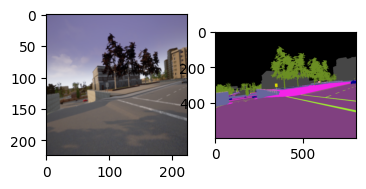

In [21]:
for i,l in zip(images, labels):
    i = i.permute(1,2,0)
    print(i.shape)
    print(l.shape)
    plt.figure(figsize = (4,4))
    plt.subplot(1,2,1)
    plt.imshow(i)
    plt.subplot(1,2,2)
    plt.imshow(l)
    break

In [22]:
# Step 4: Extract Features for Images
image_features = []
for image in images:
    image = image.unsqueeze(0)#.to(device)
    with torch.no_grad():
        features = model(image).last_hidden_state.mean(dim=1)
        image_features.append(features)
image_features = torch.cat(image_features)

*--drive--*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Now, you can save your file to the Google Drive
file_path = '/content/drive/MyDrive/image_features.pt'

In [ ]:
# Save image_features to your Google Drive
torch.save(image_features, file_path)
print(f"image_features saved to {file_path}")

In [ ]:
# Load image_features from your Google Drive
image_features = torch.load(file_path)
print("File loaded successfully from Google Drive.")

*--continuing--*

In [24]:
# Step 5: Extract Features for Semantic Label Classes
def preprocess_text(labels):
    return tokenizer(labels, padding=True, truncation=True, return_tensors="pt") # one label at a time

semantic_label_classes = ["Traffic Sign", "Building", "Fence", "Other", "Pedestrian", "Pole", "Road Line", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Unlabeled"]
text_inputs = preprocess_text(semantic_label_classes)#.to(device)
with torch.no_grad():
    text_features = CLIP(**text_inputs).last_hidden_state.mean(dim=1)

In [25]:
print(image_features.shape)
# <batch_size> images processed in ViT and their outputs saved as extracted features

print(text_features.shape)
# 13 classes, converted to text_features via tokenization THEN powers of NLP and VLM pretrained clip 

torch.Size([8, 768])
torch.Size([13, 512])


In [26]:
# Step 6: Align Features in Shared Space
projection_layer = nn.Linear(512, 768)
text_features_projected = projection_layer(text_features)

def cosine_similarity(a, b):
    a = nn.functional.normalize(a, dim=-1)
    b = nn.functional.normalize(b, dim=-1)
    return torch.matmul(a, b.T)

similarity_matrix = cosine_similarity(image_features, text_features_projected)

*Training*

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

In [12]:
dataloader_to_train = DataLoader(dataset, batch_size = batch_size, shuffle = True)
x = len(dataloader_to_train)

In [14]:
model_ft = model

In [ ]:
state_dict = torch.load("ViT_model.pth", map_location=torch.device('cpu'))
model_ft.load_state_dict(state_dict)

In [ ]:
model_ft.train()

In [ ]:
epoch_num = 50

for epoch in range(epoch_num):
    
    last_percent_done = -1
    running_loss = 0.0
    correct = 0

    for i, data in enumerate(dataloader_to_train, 0):
        inputs, processings = data
        
        # inputs = inputs.to(device)
        # processings = processings.to(device)

        processings = processings.float()
        processings = F.interpolate(processings, size=(batch_size, 768))

        optimizer.zero_grad()
        
        outputs = model_ft(inputs).last_hidden_state
        processings = processings.mean(dim=(1, 2)).long()
        loss = criterion(outputs, processings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        percent_done = int((i / len(dataloader_to_train)) * 100)
        if percent_done > last_percent_done:
            print(f"\r{epoch+1}Progress: {percent_done}%", end="")
            last_percent_done = percent_done

    print(f"\nEpoch {epoch+1} / {epoch_num} completed. Running loss: {running_loss:.3f}")
    
    if(epoch % 15):
      optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 10
    torch.save(model_ft.state_dict(), PATH)

print('Finished Training')

In [ ]:
PATH_finalized = './ViT_model.pth'
torch.save(model_ft.state_dict(), PATH_finalized)

In [ ]:
model_ft.eval()

*Prediction*

In [27]:
# Step 7: Map Similarities Back to Segmentation Maps
label_segmentation_maps = labels
predicted_segmentations = []
for idx, sim_scores in enumerate(similarity_matrix):
    label_segmentation_map = label_segmentation_maps[idx]
    label_segmentation_map = label_segmentation_map.argmax(dim=-1)
    predicted_map = torch.zeros_like(label_segmentation_map, dtype=torch.float32)
    for class_idx, label in enumerate(semantic_label_classes):
        predicted_map[label_segmentation_map == class_idx] = sim_scores[class_idx]
        # print(torch.unique(predicted_map))
    # break
    predicted_segmentations.append(predicted_map)

*--drive--*

In [ ]:
# Now, you can save your file to the Google Drive
file_path = '/content/drive/MyDrive/predicted_segmentations.pt'

In [ ]:
# Save predicted_segmentations to your Google Drive
torch.save(predicted_segmentations, file_path)
print(f"predicted_segmentations saved to {file_path}")

In [ ]:
# Load predicted_segmentations from your Google Drive
predicted_segmentations = torch.load(file_path)
print("File loaded successfully from Google Drive.")

*--continuing--*

In [28]:
len(predicted_segmentations)

8

In [29]:
# Step 8: Evaluate or Visualize Results
print("Predicted Segmentation Maps:", predicted_segmentations)

Predicted Segmentation Maps: [tensor([[-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225],
        [-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225],
        [-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225],
        ...,
        [-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225],
        [-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225],
        [-0.0225, -0.0225, -0.0225,  ..., -0.0225, -0.0225, -0.0225]],
       grad_fn=<IndexPutBackward0>), tensor([[-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        ...,
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107]],
       grad_fn=<IndexPutBackward0>), tensor([[-0.0168, -0.0168, -

In [30]:
def normalize_to_range(tensor, a, b):
    tensor_min = float(tensor.min())
    tensor_max = float(tensor.max())
    
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)    
    scaled_tensor = normalized_tensor * (b - a) + a
    
    return scaled_tensor

In [31]:
IMAGES = images
LABEL_SEGMENTATION_MAPS = label_segmentation_maps
PREDICTED_SEGMENTATIONS = predicted_segmentations

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0297, -0.0225, -0.0152], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 127, 255], dtype=torch.uint8)


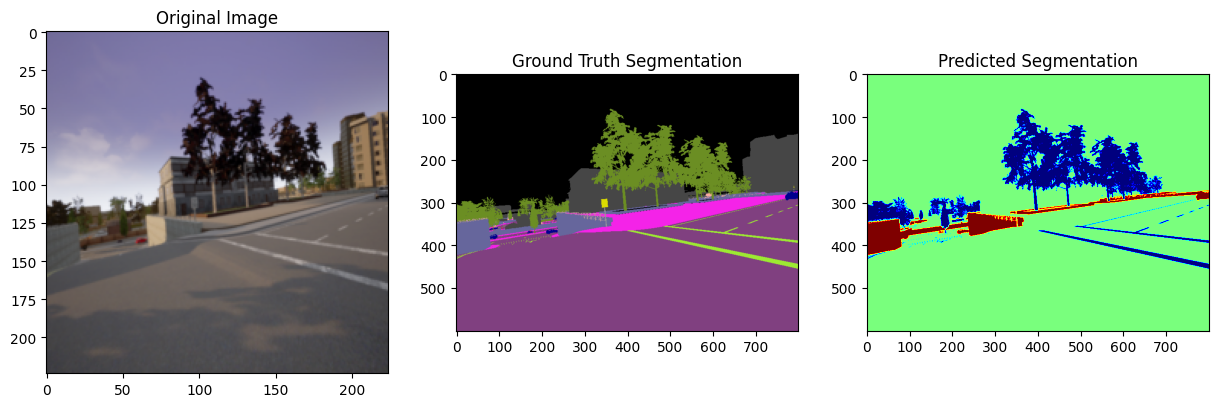

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0107,  0.0116,  0.0331], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 129, 255], dtype=torch.uint8)


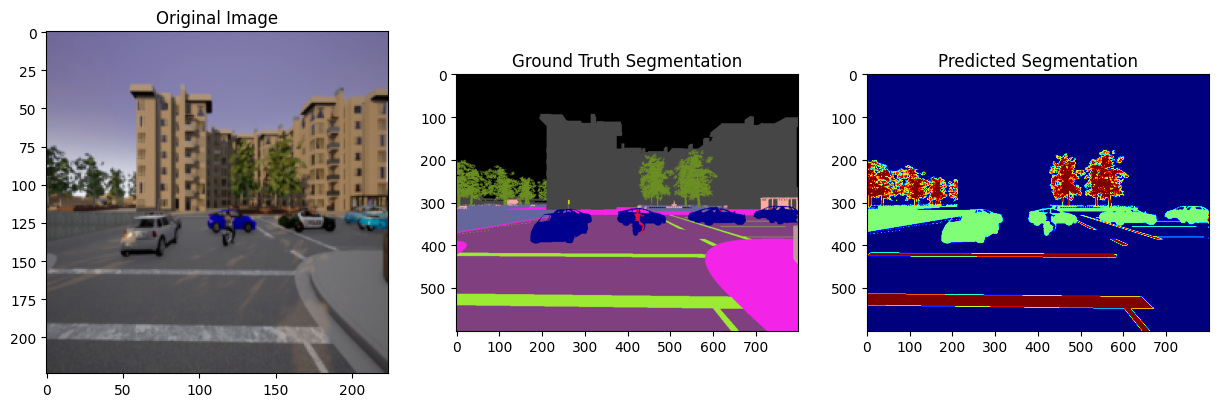

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0168,  0.0048,  0.0420], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0,  93, 255], dtype=torch.uint8)


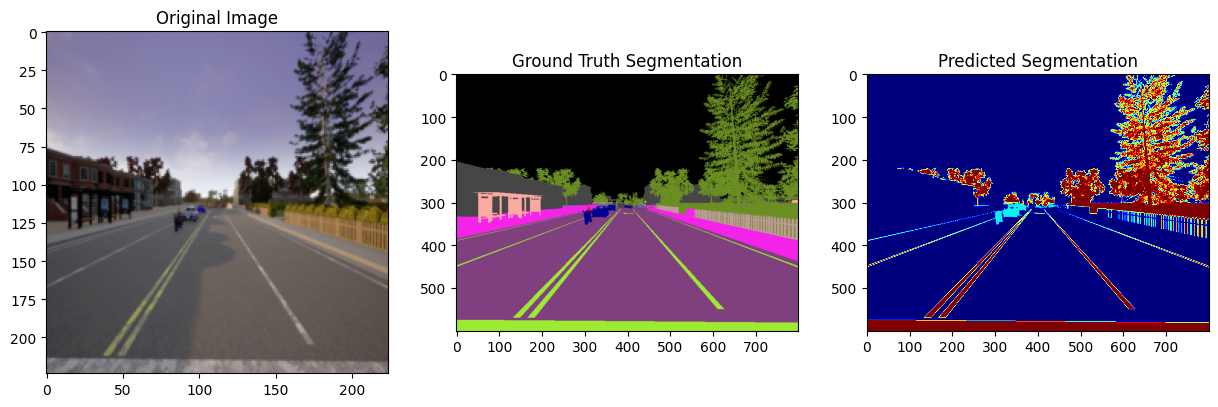

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0118,  0.0039,  0.0226], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 116, 255], dtype=torch.uint8)


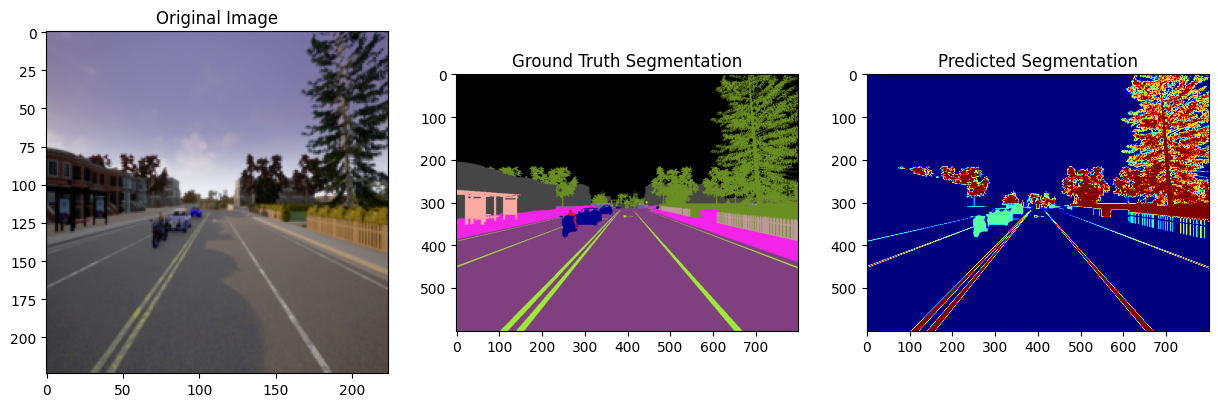

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([0.0185, 0.0643, 0.0791], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 192, 255], dtype=torch.uint8)


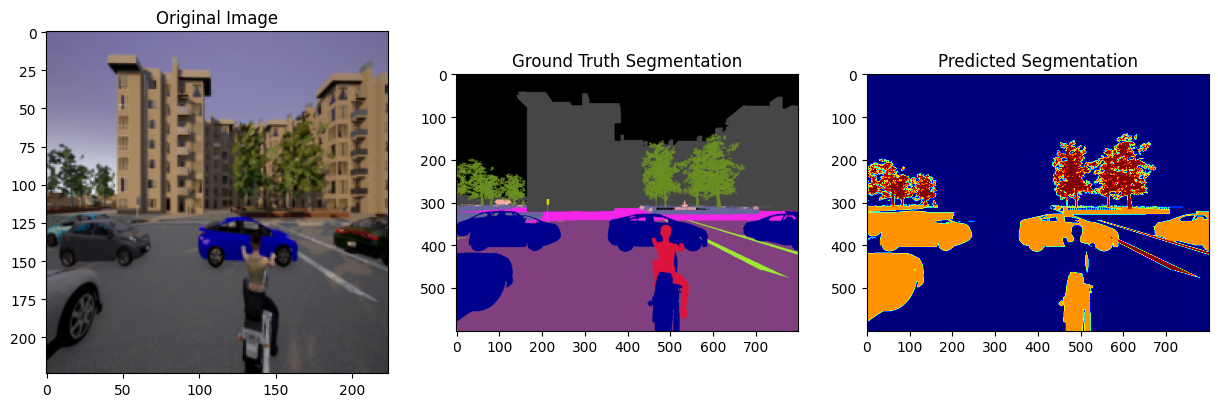

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([0.0106, 0.0168, 0.0238], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 120, 255], dtype=torch.uint8)


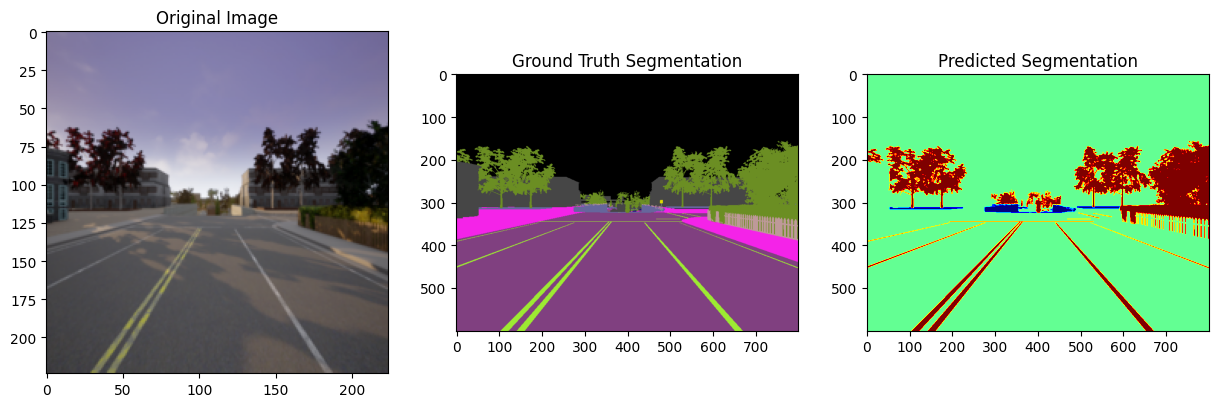

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0214, -0.0096, -0.0059], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 194, 255], dtype=torch.uint8)


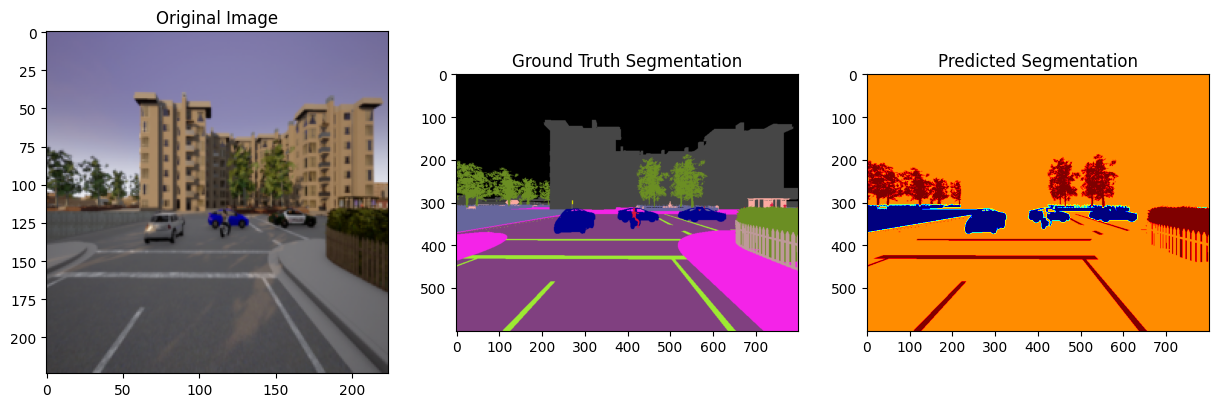

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0266, -0.0154,  0.0139], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0,  70, 255], dtype=torch.uint8)


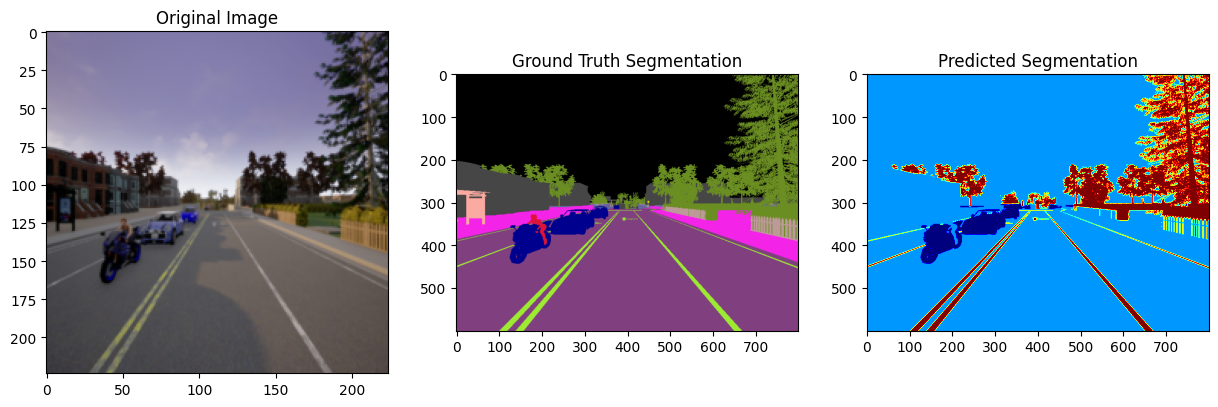

In [32]:
for i, (image, label_segmentation_map, predicted_map) in enumerate(zip(IMAGES, LABEL_SEGMENTATION_MAPS, PREDICTED_SEGMENTATIONS)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).numpy().clip(0, 1), cmap = "jet")
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(label_segmentation_map.numpy(), cmap = "jet")
    plt.title("Ground Truth Segmentation")
    print(f"SegMp: {torch.unique(label_segmentation_map)}")

    # predicted_map[predicted_map < 0] = 0
    print(f"PM (before): {torch.unique(predicted_map)}")
    print(predicted_map.shape)
    predicted_map = normalize_to_range(predicted_map, 0, 255).byte()
    print(f"PM (after): {torch.unique(predicted_map)}")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_map.detach().numpy(), cmap = "jet")
    plt.title("Predicted Segmentation")

    plt.show()

*Fine Tuning*

In [ ]:
state_dict = torch.load("ViT_model.pth", map_location=torch.device('cpu'))
model_ft.load_state_dict(state_dict)

In [33]:
model_ft = model

In [35]:
# Step 4: Extract Features for Images
image_features = []
for image in images:
    image = image.unsqueeze(0)#.to(device)
    with torch.no_grad():
        features = model_ft(image).last_hidden_state.mean(dim=1)
        image_features.append(features)
image_features = torch.cat(image_features)

In [37]:
# Step 5: Extract Features for Semantic Label Classes
def preprocess_text(labels):
    return tokenizer(labels, padding=True, truncation=True, return_tensors="pt") # one label at a time

semantic_label_classes = ["Traffic Sign", "Building", "Fence", "Other", "Pedestrian", "Pole", "Road Line", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Unlabeled"]
text_inputs = preprocess_text(semantic_label_classes)#.to(device)
with torch.no_grad():
    text_features = CLIP(**text_inputs).last_hidden_state.mean(dim=1)

In [38]:
# Step 6: Align Features in Shared Space
projection_layer = nn.Linear(512, 768)
text_features_projected = projection_layer(text_features)

def cosine_similarity(a, b):
    a = nn.functional.normalize(a, dim=-1)
    b = nn.functional.normalize(b, dim=-1)
    return torch.matmul(a, b.T)

similarity_matrix = cosine_similarity(image_features, text_features_projected)

In [39]:
# Step 7: Map Similarities Back to Segmentation Maps
label_segmentation_maps = labels
predicted_segmentations = []
for idx, sim_scores in enumerate(similarity_matrix):
    label_segmentation_map = label_segmentation_maps[idx]
    label_segmentation_map = label_segmentation_map.argmax(dim=-1)
    predicted_map = torch.zeros_like(label_segmentation_map, dtype=torch.float32)
    for class_idx, label in enumerate(semantic_label_classes):
        predicted_map[label_segmentation_map == class_idx] = sim_scores[class_idx]
        # print(torch.unique(predicted_map))
    # break
    predicted_segmentations.append(predicted_map)

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0297, -0.0225, -0.0152], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 127, 255], dtype=torch.uint8)


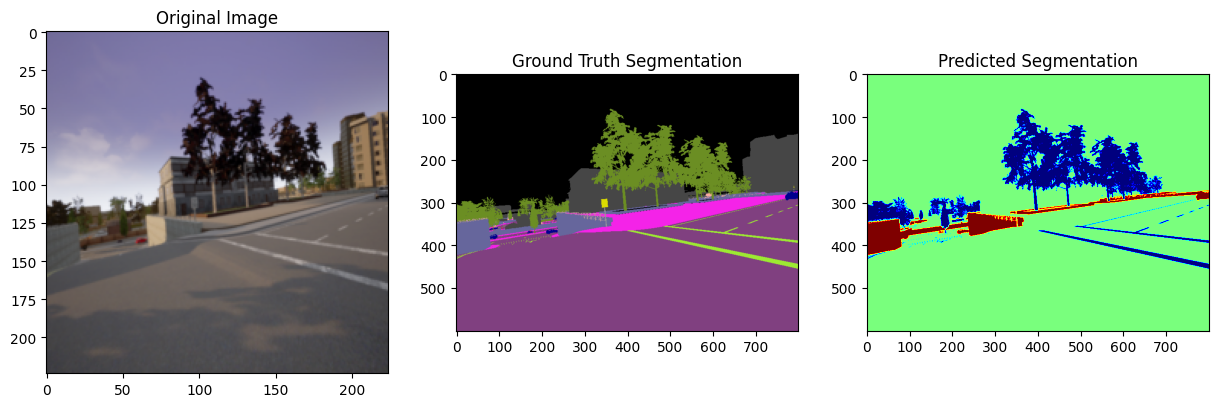

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0107,  0.0116,  0.0331], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 129, 255], dtype=torch.uint8)


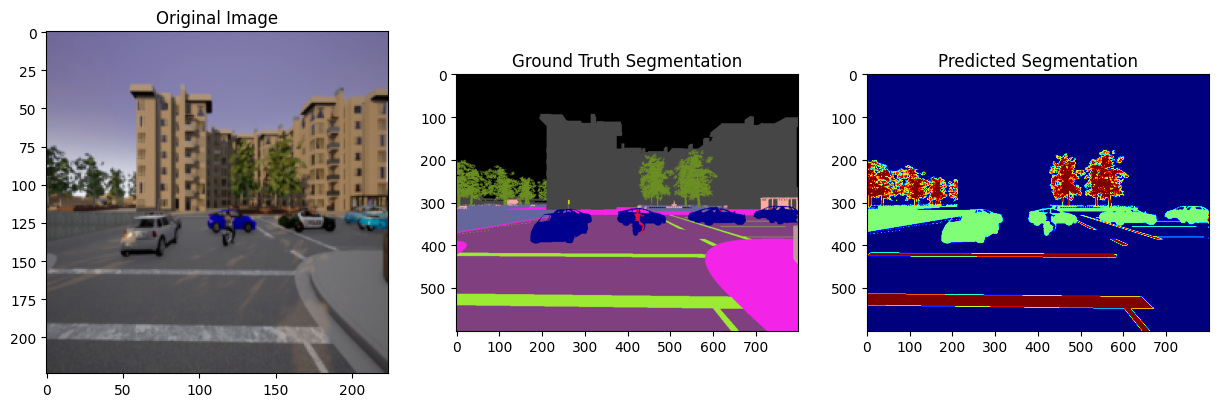

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0168,  0.0048,  0.0420], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0,  93, 255], dtype=torch.uint8)


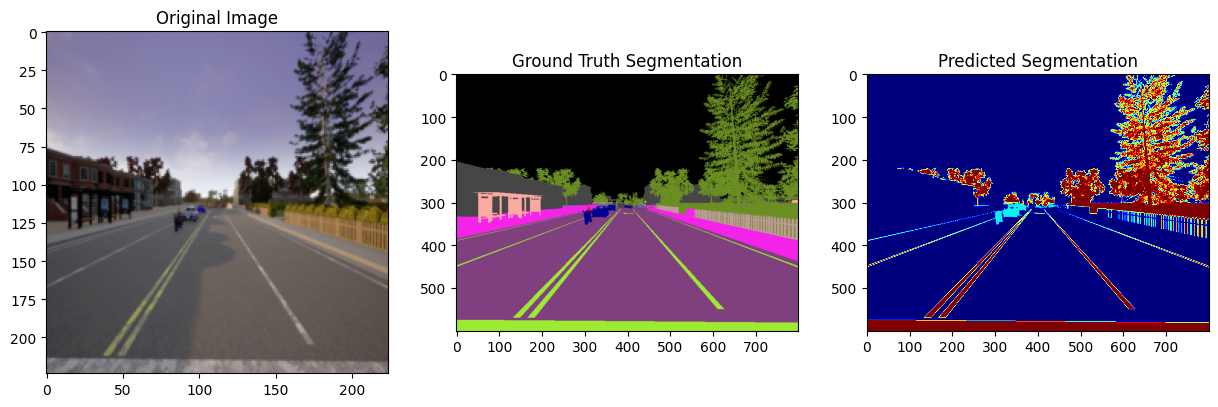

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0118,  0.0039,  0.0226], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 116, 255], dtype=torch.uint8)


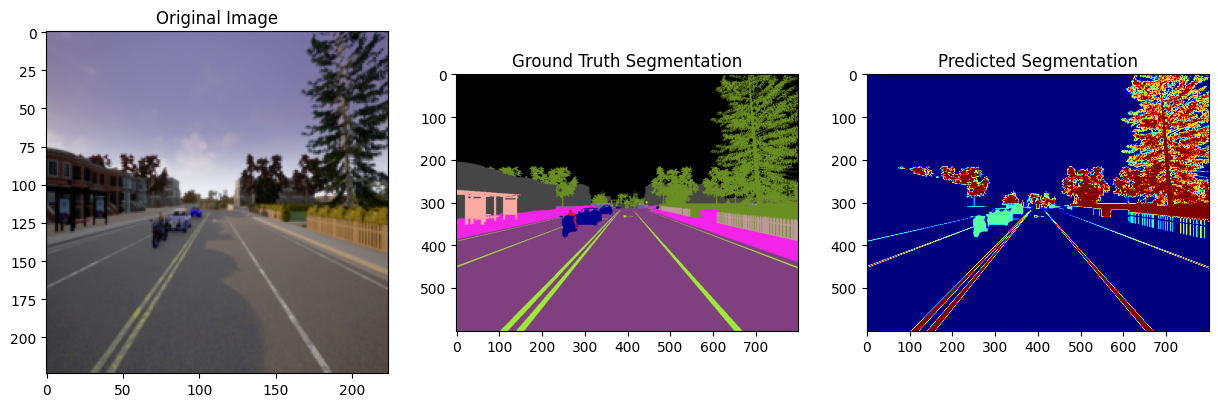

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([0.0185, 0.0643, 0.0791], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 192, 255], dtype=torch.uint8)


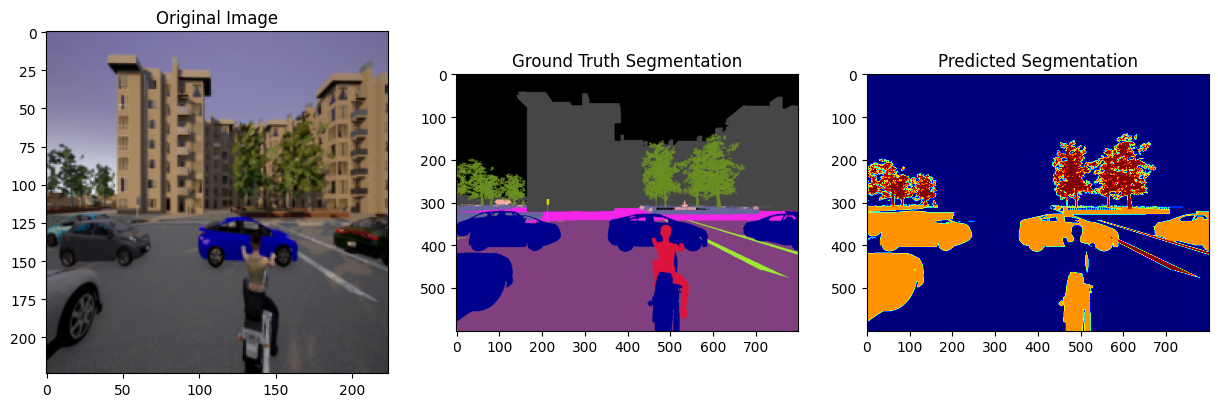

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([0.0106, 0.0168, 0.0238], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 120, 255], dtype=torch.uint8)


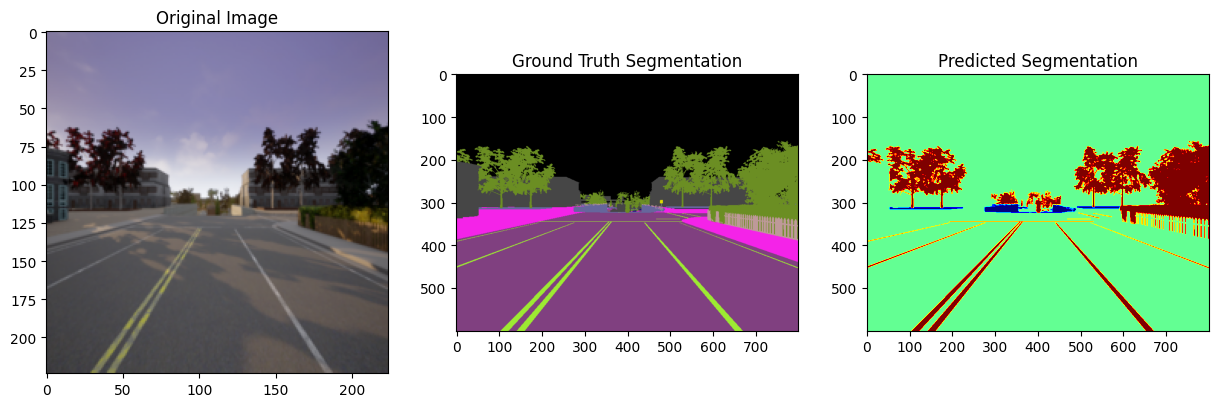

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0214, -0.0096, -0.0059], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0, 194, 255], dtype=torch.uint8)


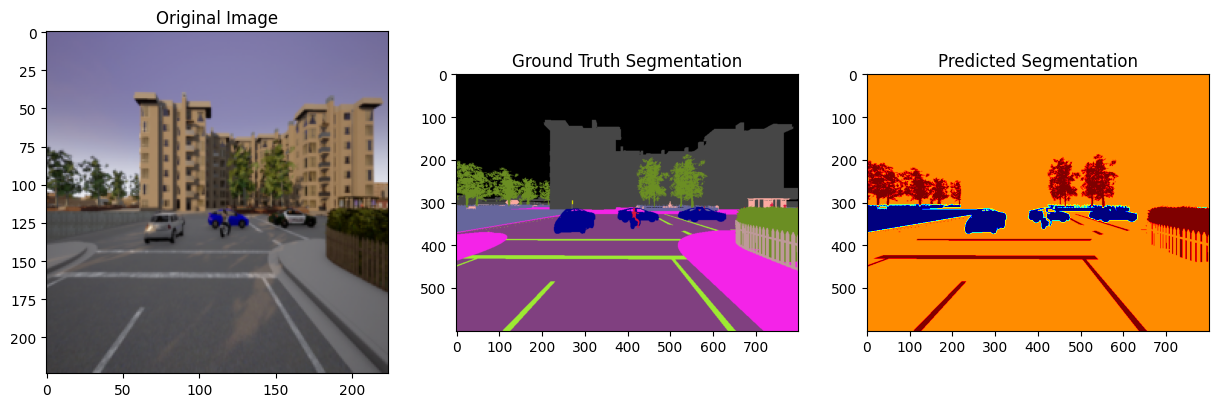

SegMp: tensor([  0,  20,  35,  50,  60,  64,  70, 102, 107, 128, 142, 153, 156, 157,
        160, 170, 190, 220, 232, 234, 244, 250])
PM (before): tensor([-0.0266, -0.0154,  0.0139], grad_fn=<Unique2Backward0>)
torch.Size([600, 800])
PM (after): tensor([  0,  70, 255], dtype=torch.uint8)


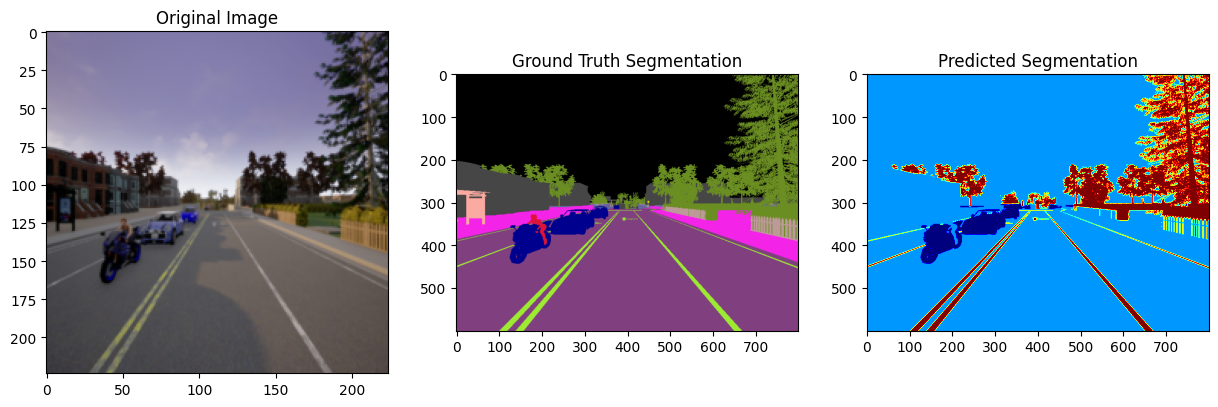

In [40]:
for i, (image, label_segmentation_map, predicted_map) in enumerate(zip(IMAGES, LABEL_SEGMENTATION_MAPS, PREDICTED_SEGMENTATIONS)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).numpy().clip(0, 1), cmap = "jet")
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(label_segmentation_map.numpy(), cmap = "jet")
    plt.title("Ground Truth Segmentation")
    print(f"SegMp: {torch.unique(label_segmentation_map)}")

    # predicted_map[predicted_map < 0] = 0
    print(f"PM (before): {torch.unique(predicted_map)}")
    print(predicted_map.shape)
    predicted_map = normalize_to_range(predicted_map, 0, 255).byte()
    print(f"PM (after): {torch.unique(predicted_map)}")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_map.detach().numpy(), cmap = "jet")
    plt.title("Predicted Segmentation")

    plt.show()